# Exploratory Data Analysis

This notebook contains the exploratory data analysis for the bank fraud detection dataset. It is split into multiple sections being 

- Initial understanding of the data
- Exploring the features 
    - Numerical data
    - Categorical data
- Identify possible transformations 

### 1. Initial understanding of the data

In [1]:
# Import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm


In [2]:
# Data collection
total_df = pd.read_csv('./Data/Base.csv')

# Split the DataFrame into training and test sets using stratified sampling to maintain anomaly distribution
train_df, test_df = train_test_split(total_df, test_size=0.2, stratify=total_df['fraud_bool'], random_state=42)

# Validate the size of the data
train_shape = train_df.shape
test_shape = test_df.shape
print(f"The training data has {train_shape[0]} rows and {train_shape[1]} columns.")
print(f"The testing data has {test_shape[0]} rows and {test_shape[1]} columns.")

The training data has 800000 rows and 32 columns.
The testing data has 200000 rows and 32 columns.


We start the EDA by importing data from the Base.csv file and split this up into training and test data to avoid data leakage. The split is done using stratified sampling from the "fraud_bool" feature which preserves output distribution due to most likely unbalanced features. We can see that the data has 32 columns where the training data contains 80000 samples and the test data has 20000. Next we can have a quick look at what the dataframe looks like.

In [3]:
# Shows the first 5 observations of the training data
train_df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
39111,0,0.7,0.229712,-1,63,50,0.024720,50.674001,AA,1305,...,1,1500.0,0,INTERNET,3.580550,linux,0,1,0,0
822700,0,0.2,0.928428,199,24,70,0.014153,15.631407,AA,833,...,0,500.0,0,INTERNET,7.087779,other,1,1,0,6
914415,0,0.1,0.658630,95,2,40,0.045801,-1.410133,AB,237,...,0,200.0,0,INTERNET,0.547804,other,1,1,0,7
581307,0,0.8,0.774858,-1,122,30,0.005569,-0.539938,AB,895,...,1,500.0,0,INTERNET,4.671407,other,1,1,0,4
603136,0,0.9,0.993460,103,9,20,0.010832,-0.501067,AB,4105,...,1,200.0,0,INTERNET,9.293206,linux,0,1,0,4


Above, we can see that the data consists of a target variable called fraud_bool along with many features which give information on whether a certain bank account is fraudulent. The name fraud_bool hints at it being a boolean feature so we can check the different possible outputs in the fraud_bool feature and their distribution by doing the following

In [4]:
# Find the unique values of fraud_bool and prints their distribution
unique_outputs= train_df['fraud_bool'].unique()
print(f"The unique values in the column are: {', '.join(map(str, unique_outputs))}")

# Get the distribution of the fraud_bool
distribution = train_df['fraud_bool'].value_counts(normalize=True)
print("\nDistribution of the output variable:")
for value, proportion in distribution.items():
    print(f"Value {value}: {proportion:.2%}")



The unique values in the column are: 0, 1

Distribution of the output variable:
Value 0: 98.90%
Value 1: 1.10%


Now we see us that our problem is a binary classification problem because we only have two outputs 0 and 1. We also see that our data is highly imbalanced as 98.9% of the data is not fraudulent whereas 1.1% is a fraud. This will need to be taken into account for the preprocessing of the data. Moving on we can calculate the types of all of the features to determine what we are dealing with

In [5]:
# Print the column names, non-null count and datatype
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800000 entries, 39111 to 228494
Data columns (total 32 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   fraud_bool                        800000 non-null  int64  
 1   income                            800000 non-null  float64
 2   name_email_similarity             800000 non-null  float64
 3   prev_address_months_count         800000 non-null  int64  
 4   current_address_months_count      800000 non-null  int64  
 5   customer_age                      800000 non-null  int64  
 6   days_since_request                800000 non-null  float64
 7   intended_balcon_amount            800000 non-null  float64
 8   payment_type                      800000 non-null  object 
 9   zip_count_4w                      800000 non-null  int64  
 10  velocity_6h                       800000 non-null  float64
 11  velocity_24h                      800000 non-null  fl

Here we get the information that we have no null features or missing features meaning that data imputation won't be necessary for our project. We have numerical features with the type "float64" and categorical features with the type "int64" and "object". We also need to account for that some of our float data also could be categorical so we can find them by counting the number of unique values of the float columns. 

In [6]:
# Number of unique values of the float data
train_df.select_dtypes(include=['float64']).nunique()  

income                            9
name_email_similarity        799289
days_since_request           793121
intended_balcon_amount       796805
velocity_6h                  799150
velocity_24h                 799310
velocity_4w                  798908
proposed_credit_limit            12
session_length_in_minutes    796391
dtype: int64

Which shows us that income and proposed_credit_limit is a categorical feature. Now we can Let's create 2 seperate dataframes for these different feature categories and study them seperately

In [7]:
# Create numerical dataframe
num_df = train_df.select_dtypes(include=['float64']).drop(columns=['income', 'proposed_credit_limit'])

# Create categorical dataframe
cat_df = train_df.select_dtypes(include=['int64', 'object']).copy()
cat_df[['income', 'proposed_credit_limit']] = train_df[['income', 'proposed_credit_limit']]
cat_df['income'] = cat_df['income'].round(1)
cat_df['proposed_credit_limit'] = cat_df['proposed_credit_limit'].round(0).astype('int64')


## 2. Exploring the features individually

### 2.1 Numerical features

We start by analysing the numerical features. The first thing we can check is the statistics of the data such as the mean and standard deviations. 

In [8]:
num_df.describe()

,name_email_similarity,days_since_request,intended_balcon_amount,velocity_6h,velocity_24h,velocity_4w,session_length_in_minutes
count,800000.000000,8.000000e+05,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000
mean,0.493798,1.024099e+00,8.665099,5664.020229,4770.234656,4856.003621,7.549768
std,0.289099,5.377299e+00,20.232373,3009.677961,1479.503976,919.619696,8.044859
min,0.000001,4.036860e-09,-15.530555,-170.603072,1320.283991,2825.748405,-1.000000
25%,0.225325,7.181675e-03,-1.181143,3434.759967,3593.073983,4268.308917,3.104958
50%,0.492314,1.516505e-02,-0.829849,5316.302685,4750.803340,4913.542421,5.113827
75%,0.755595,2.631458e-02,5.074825,7680.990796,5753.115565,5487.683683,8.866801
max,0.999999,7.845690e+01,112.956928,16715.565404,9506.896596,6994.764201,85.899143


Looking the table above we can see that the features called velocity have a very high mean. When reading the documentation about the dataset we learn that velocity is the average number of applications per hour during the stated time in the feature (velocity_6h is the last 6 hours). One can already speculate that perhaps looking 4 weeks back when averaging per hour won't be a necessary feature since it is over such a long time span that frauds will cancel out in the mix. Another possible issue is that these features will be highly dependant and can probably be combined. Another noticable thing is that the standard deviation of days_since_request is very large indicating that this feature could be highly imbalanced and skewed. Another interesting aspect is that the minimum value of session_length_in_minutes is -1 and the minimum velocity is negatice which could mean that this value is a placeholder for something else since negative time isn't possible. Further analysis will need to be done on the features individually to determine proper transformations that should be done to the dataset. Finally we see that name_email_similarity has a minimum of 0 and a maximum of 1 which indiciates that this is perhaps a categorical feature too. The first step to analyse the numerical features further will be to look at their distributions together with outliers. 

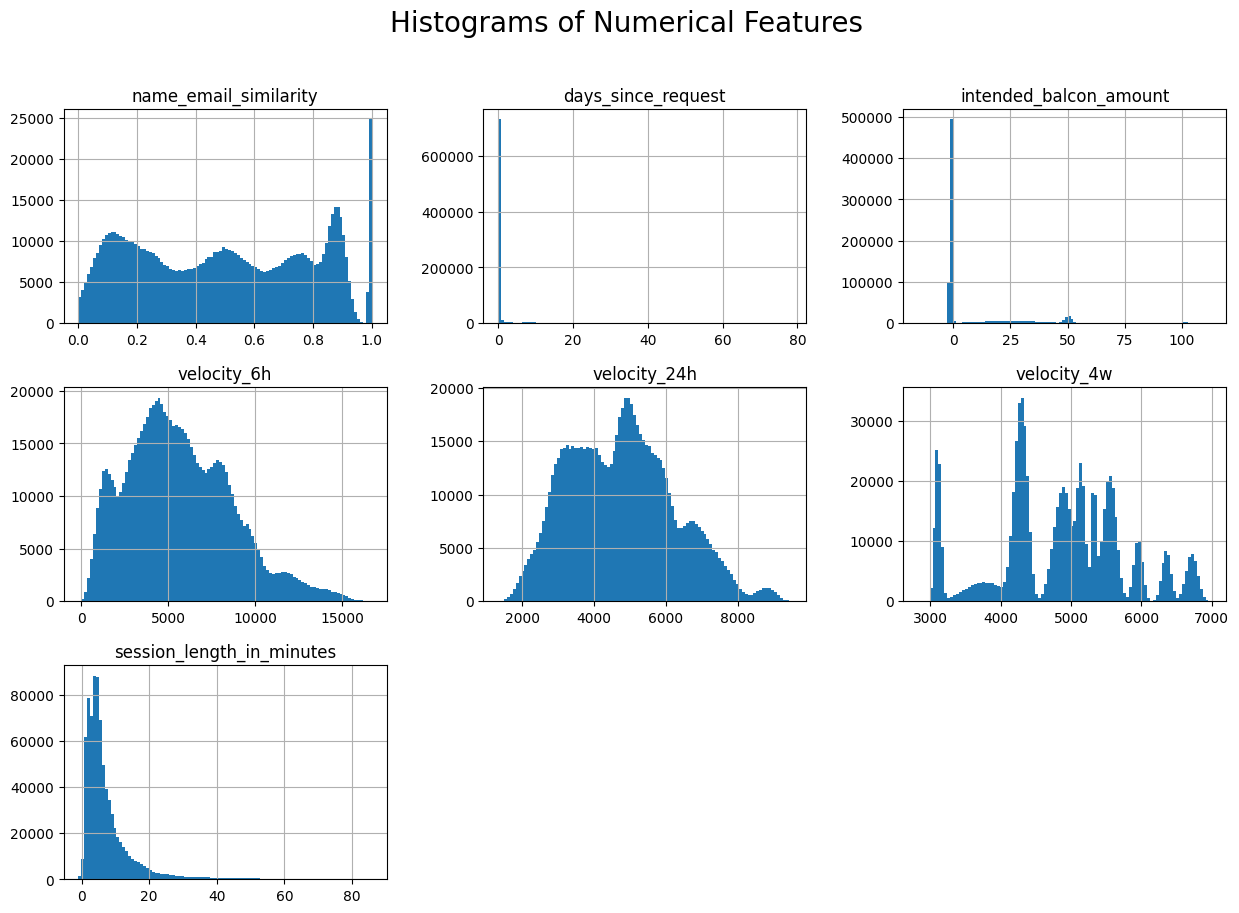

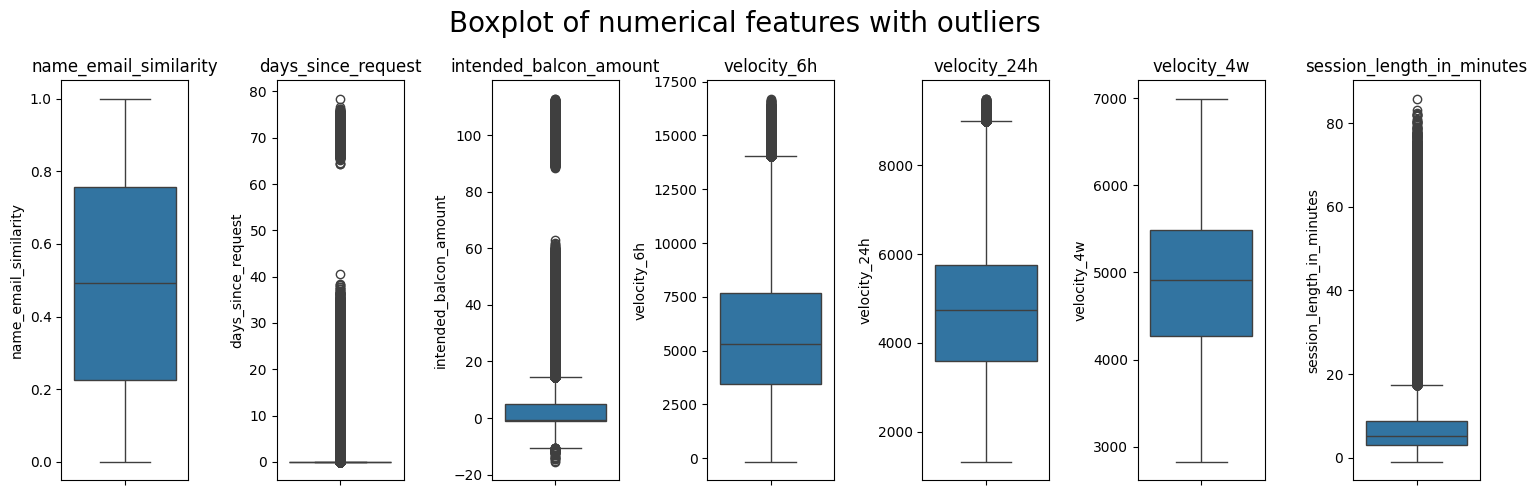

In [9]:
# Histograms of the numerical features
num_df.hist(bins=100, figsize=(15, 10))
plt.suptitle('Histograms of Numerical Features', fontsize=20)
plt.show()

# Boxplots for the numerical features
fig, axes = plt.subplots(1, len(num_df.columns), figsize=(15, 5))
axes = axes.flatten()
for i in range(len(num_df.columns)):
    sns.boxplot(data = num_df.iloc[:, i], ax=axes[i])
    axes[i].set_title(num_df.columns[i])

fig.suptitle('Boxplot of numerical features with outliers', fontsize=20)
plt.tight_layout()


What we can see above is that the name_email_similarity appears to follow a pretty uniform distribution with some emails apart from the peak at 1. There is a lower limit of 0 and the upper being 1 which means that this should converted into a categorical feature using binning with perhaps 5 bins and one of the bins will be value greater than 0.96 to account for the spike and the other 4 bins will have size 0.24. 

The days_since_request feature appears to follow a steep exponential distribution assuming that there is constant rate of days since the request but with a grouping of outliers around 65-80 days and the requests being 1-45 days also being unique. Since an exponential distribution has the form $f(x)=\lambda e^{-\lambda x}$ a log-transform can be used to make it more uniform and the outliers will be analysed to see if they are correlated with the output otherwise they are removed. 

The intended_balcon_amount is the initial transfer that the applicant wants to put into the account. We see that there are many people who have slightly negative sums to their account most likely due to fees and another group without fees. Most likely a fraudulent account won't be placing money into the account so we can further analyse the probability that accounts with money are fraudulent. In that case it might be best to turn this into a binary categorical feature since the amount itself doesn't have a clear distribution.

For the velocity over the last hours they seem to be normally distributed but probably highly correlated. If their correlation is too high then they can be combined into one feature. The velocity over 4 weeks almost appears random so we believe this feature should be removed completely. The outliers can also reasonably be removed. Finally to handle the negative values of velocity_6w we can do further analysis on it

Finally the session length in minutes appears to be exponentially distributed so we can use a log-transform however we saw previously that there are negative values. We should check if this has any correlation with the output and otherwise we will remove these values. Additionally a log-transform will also be benficial to get rid of the exponential part. 

The next step of our analysis will be to check if the outliers in days_since_request, the positive values of intended_balcon_amount and the negative values of session_length_in_minutes significantly differ from the output distribution. We do these tests by doing a hypothesis test on a Bernoulli distribution:

In [10]:
# Calculate null hypothesis
null_counts = train_df['fraud_bool'].value_counts()
null_total = null_counts.sum()
null_fraud = null_counts.get(1, 0)
null_p = null_fraud / null_total

# Calculate the upper bound for outliers in 'days_since_request'
upper_bound = train_df['days_since_request'].quantile(0.75) + 1.5 * (train_df['days_since_request'].quantile(0.75)-train_df['days_since_request'].quantile(0.25))

# List of conditions with their descriptions
conditions = [
    ('Small outliers in days_since_request', (train_df['days_since_request'] > upper_bound) & (train_df['days_since_request'] < 50)),
    ('Large outliers in days_since_request', train_df['days_since_request'] > 50),
    ('Positive accounts in intended_balcon_amount', train_df['intended_balcon_amount'] > 0),
    ('Negative session times', train_df['session_length_in_minutes'] < 0),
    ('Negative velocity values', train_df['velocity_6h'] < 0)
]

# Initialize dataframe list
results = [{
    'Part of dataframe': 'Null hypothesis',
    'Probability of fraud': null_p,
    'Number of observations': null_total,
    'P-value': 1
}]

# Loop over conditions to compute probabilities and p-values
for description, condition in conditions:
    subset = train_df[condition]
    subset_counts = subset['fraud_bool'].value_counts()
    subset_total = subset_counts.sum()
    subset_fraud = subset_counts.get(1, 0)
    
    if subset_fraud > 0:
        subset_p = subset_fraud / subset_total
        p_value = sm.stats.proportions_ztest([null_fraud, subset_fraud], [null_total, subset_total])[1]
    else:  
        subset_p = 0
        p_value = None
    
    results.append({
        'Part of dataframe': description,
        'Probability of fraud': subset_p,
        'Number of observations': subset_total,
        'P-value': p_value
    })

# Create and print hypothesis dataframe
hypothesis_df = pd.DataFrame(results)
hypothesis_df.style.format({'P-value': '{:.2e}'}).hide(axis='index')

Part of dataframe,Probability of fraud,Number of observations,P-value
Null hypothesis,0.011029,800000,1.00e+00
Small outliers in days_since_request,0.013329,72921,1.64e-08
Large outliers in days_since_request,0.013145,2967,2.71e-01
Positive accounts in intended_balcon_amount,0.004958,206132,1.35e-137
Negative session times,0.009858,1623,6.52e-01
Negative velocity values,0.000000,36,nan


As we can see above our small outliers with a p-value of the order $10^-8$ contains information about the output and the large outliers probably also do but we don't have enough samples to be sure so we should group them together. The most fascinating part is that the accounts with a positive balance only have less than 0.5% chance of being fraudulent instead of 1.1% which is very useful for our model and can be made into a feature. Unfortunatly the negative session times don't seem to convey any useful information about the output probabilities. We also see that the negative velocity values don't convey much information so we can simply replace them with 0. In general all of this means that we should create seperate features for whether an observation in days_since_request is an outlier and if an account in intended_balcon_amount is positive. However days_since_request contains a useful exponential distribution we will keep the numerical data as a feature too but will delete intended_balcon_amount to reduce overfitting on unclear numerical data. 

Finally the last part of analysing the numerical features is to look at the correlation between the velocities. Doing this we get:

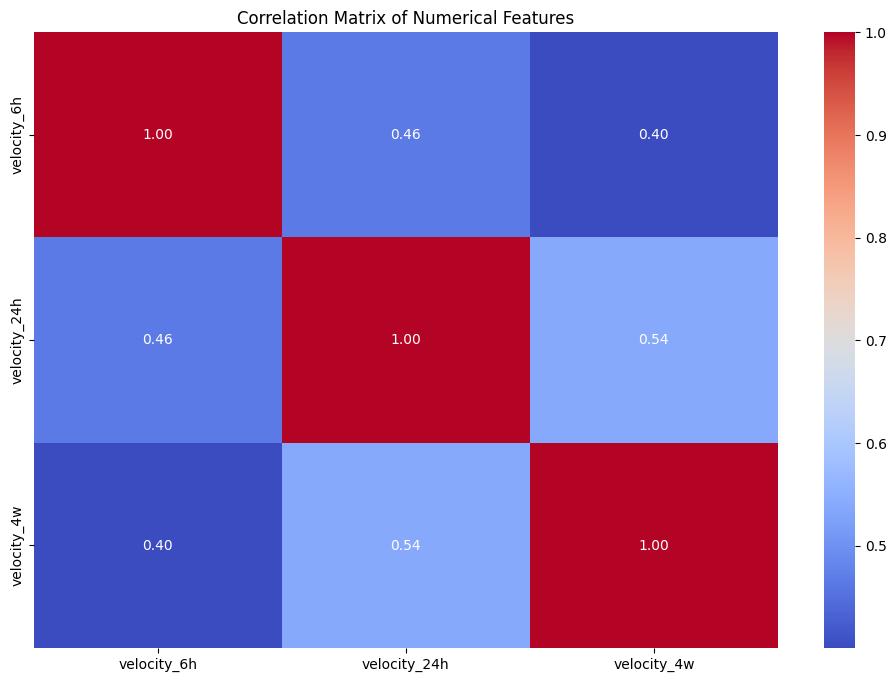

In [11]:
# Correlation matrix for numerical features
plt.figure(figsize=(12, 8))
sns.heatmap(num_df[['velocity_6h', 'velocity_24h', 'velocity_4w']].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()


Where we can see that our velocity_6h and velocity_24h features are moderatly correlated but not high to warrant removing one of them and velocity_24 has already been decided to be removed. Further correlation analysis will be done later

### Summary of feature transformations for numerical features

Name_email_similarity:
- Convert into 5 bins, 4 with range 0.24 and 1 with range 0.04 (0.96-1)
- There are no outliers

Days_since_request:
- Use a log transform and then remove outliers
- Add boolean feature called is_days_since_request_outlier 

Intended_balcon_amount
- Delete and instead add boolean feature called has_positive_account

Velocity_6h, _24h, 4w
- Remove velocity_4w
- Set negative values in velocity_6w to 0
- Remove outliers and keep the rest

Session_length_in_minutes
- Keep it and use log-transform



## 2.2 Categorical Features

Now that we have analysed the numerical features the next step is to look at the categorical ones. We can start by looking at how many unique values each feature has.

In [12]:
cat_df.nunique()

fraud_bool                             2
prev_address_months_count            374
current_address_months_count         421
customer_age                           9
payment_type                           5
zip_count_4w                        6268
bank_branch_count_8w                2318
date_of_birth_distinct_emails_4w      40
employment_status                      7
credit_risk_score                    550
email_is_free                          2
housing_status                         7
phone_home_valid                       2
phone_mobile_valid                     2
bank_months_count                     33
has_other_cards                        2
foreign_request                        2
source                                 2
device_os                              5
keep_alive_session                     2
device_distinct_emails_8w              4
device_fraud_count                     1
month                                  8
income                                 9
proposed_credit_

We see that we have some categorical features with many category, some with a few categories and some which are simply a boolean. Additionally we see we have a feature called device_fraud_count with only one category which is the number of fraudulent applications with used device. In our training data this turns out to always be 0 but we should still keep it as a boolean feature. All of this creates a natural split of dividing up the EDA into analysis of high-cardinality categorical features, low-cardinality features and boolean features. We decide do to the split that more features than 12 is high-cardinality. 

In [13]:
# Create the high and low cardinality categorical dataframes
highcard_df = cat_df[[col for col in cat_df.columns if cat_df[col].nunique() > 12]]
lowcard_df = cat_df[[col for col in cat_df.columns if (cat_df[col].nunique() <= 12) & (cat_df[col].nunique() > 2)]]
bool_df = cat_df[[col for col in cat_df.columns if cat_df[col].nunique() <= 2]]

### 2.2a) High cardinality categorical features - ANALYSIS NOT COMPLETE

The high cardinality categorical features have been placed into a dataframe called highcard_df which we can start to examine by looking at it's statistics and distributions

In [14]:
highcard_df.describe()

,prev_address_months_count,current_address_months_count,zip_count_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,bank_months_count
count,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000
mean,16.700988,86.614125,1572.765860,184.301711,9.504231,131.014702,10.849090
std,44.017921,88.391093,1005.233667,459.482233,5.038498,69.679675,12.120893
min,-1.000000,-1.000000,1.000000,0.000000,0.000000,-170.000000,-1.000000
25%,-1.000000,19.000000,894.000000,1.000000,6.000000,83.000000,-1.000000
50%,-1.000000,52.000000,1263.000000,9.000000,9.000000,122.000000,5.000000
75%,12.000000,130.000000,1944.000000,25.000000,13.000000,178.000000,25.000000
max,383.000000,428.000000,6700.000000,2385.000000,39.000000,389.000000,32.000000


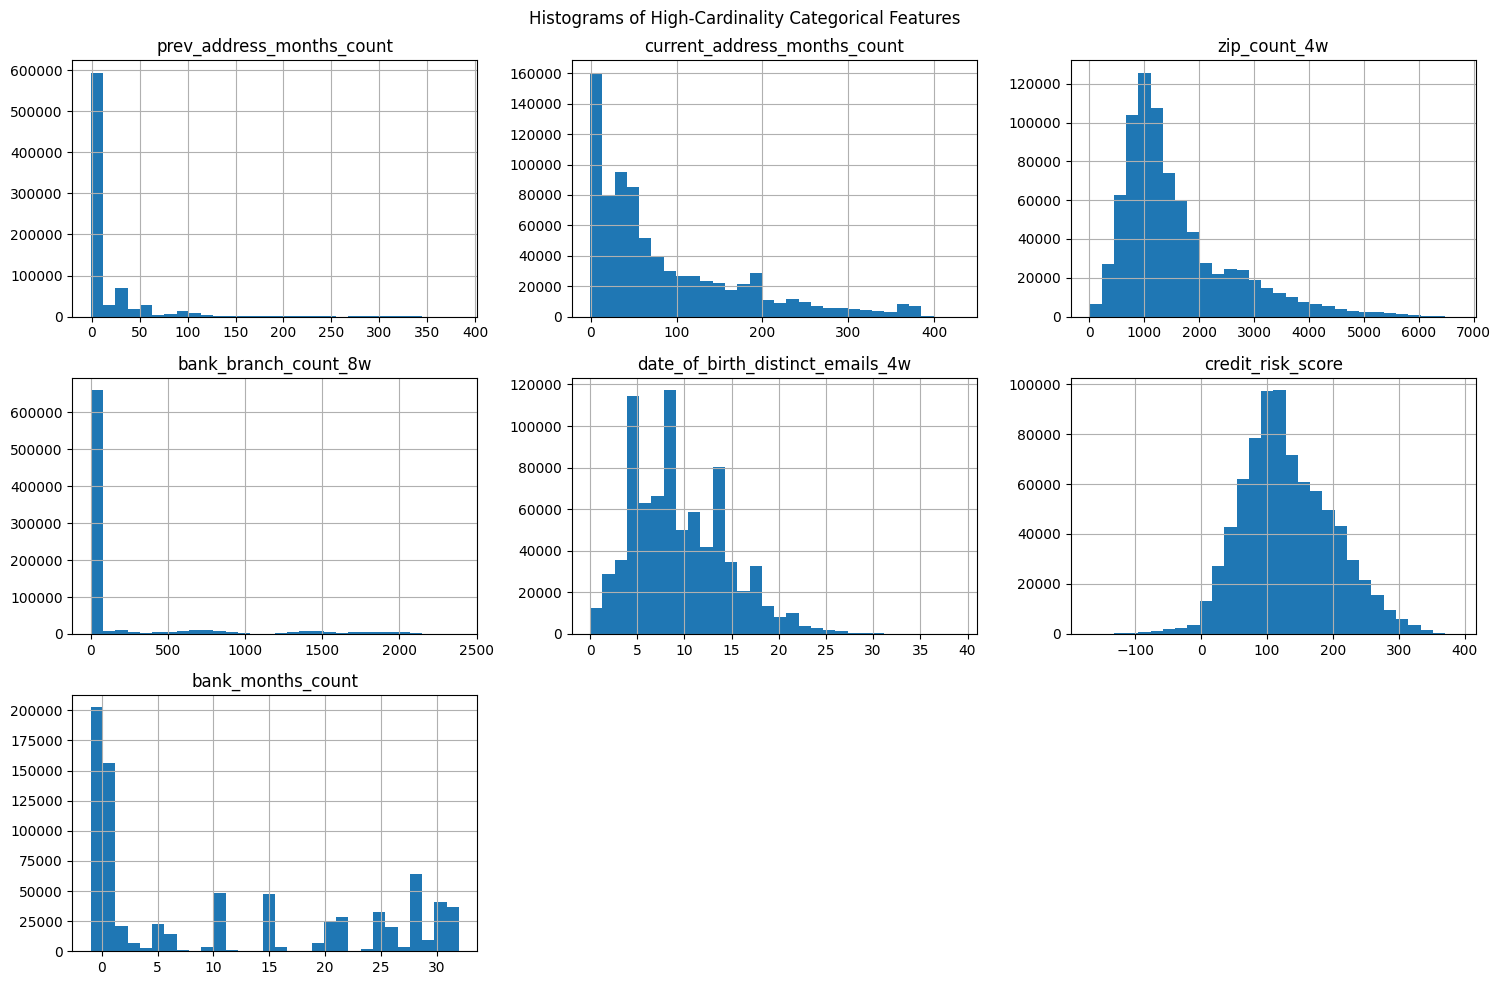

In [15]:
highcard_df.hist(bins=30, figsize=(15, 10))
plt.suptitle('Histograms of High-Cardinality Categorical Features')
plt.tight_layout()
plt.show()

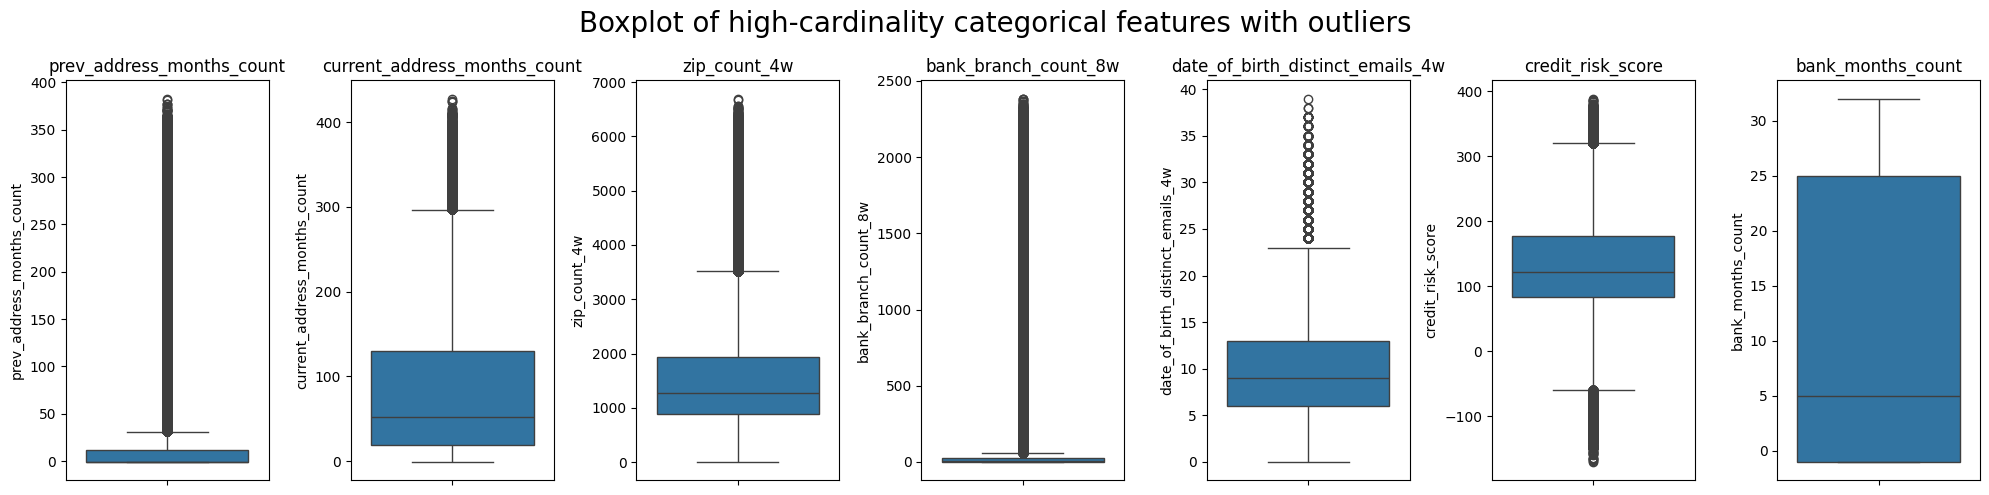

In [16]:
# Boxplots for the high-cardinality categorical features
fig, axes = plt.subplots(1, len(highcard_df.columns), figsize=(20, 5))
axes = axes.flatten()
for i in range(len(num_df.columns)):
    sns.boxplot(data = highcard_df.iloc[:, i], ax=axes[i])
    axes[i].set_title(highcard_df.columns[i])

fig.suptitle('Boxplot of high-cardinality categorical features with outliers', fontsize=20)
plt.tight_layout()

For the prev_address_months_count we can see that there are many values of -1 with the minimum and Q1 also being -1. This could be an important feature and will be tested to see if it is beneficial for our model. The rest of the features look pretty randomly distributed so it is most likely sufficient to just convert this into a boolean variable to check if it equals -1. 

For current_address_months_count we can do the same where we test the features which are -1 but now we have information in the tail of the distribution. It looks right skewed which we can fix using a log-transform. There is also a little bump around 380 which could affect the scaling process but we decide to keep it for now. Ordinal encoding will be the best way to handle the data since we have so many categories. 

The zip_count_data is probably the cleanest data we have seen so far and with a log-transform to make it normal and removing outliers it will be ready to be used in the model directly. There are so many categories we should use ordinal encoding because two zip codes nearby are closer to eachother and one-hot encoding would lose this information. 

Bank_branch_count_8w has many 0 values which will need to be analysed if we want to add it as a boolean feature. If an applicant has made very many applications it would probably be a fraud but the exact value isn't as important. One way to encode this is by using binning such as 0, 0-5, 5-20, 20-50, 50-100, 100+.

For the feature number of emails with the same date of birth the last 4 weeks I think that only abnormally large values are interesting and the rest would just be normally distributed. The classifier could to do this distinction by itself so I think we should simply keep all of the data and scale it down. We have a few data points with many samples but this could be just pure coincidence.

The credit_risk_score feature can be seen to have negative values but this shouldn't be an issue since we can translate the feature when scaling. It also looks close to normal but with outliers that can be removed and many categories which means we are going to use ordinal encoding. 

The bank_months_count feature looks a bit strange with a wide range of values from -1 to 32, and a lot of clustering toward the lower end. We see a concentration of data points with a small count of months, which may represent users with new accounts. The -1 values could indicate missing data, so it’s important to test whether they are beneficial for the model by converting them into a boolean feature or imputing them with a reasonable value. The data is right-skewed, so applying a log-transform would likely help make the distribution more normal. Additionally, the distribution suggests that ordinal encoding will be the best way to handle the data.

### 2.2b) Low-cardinality categorical features - ANALYSIS NOT COMPLETE

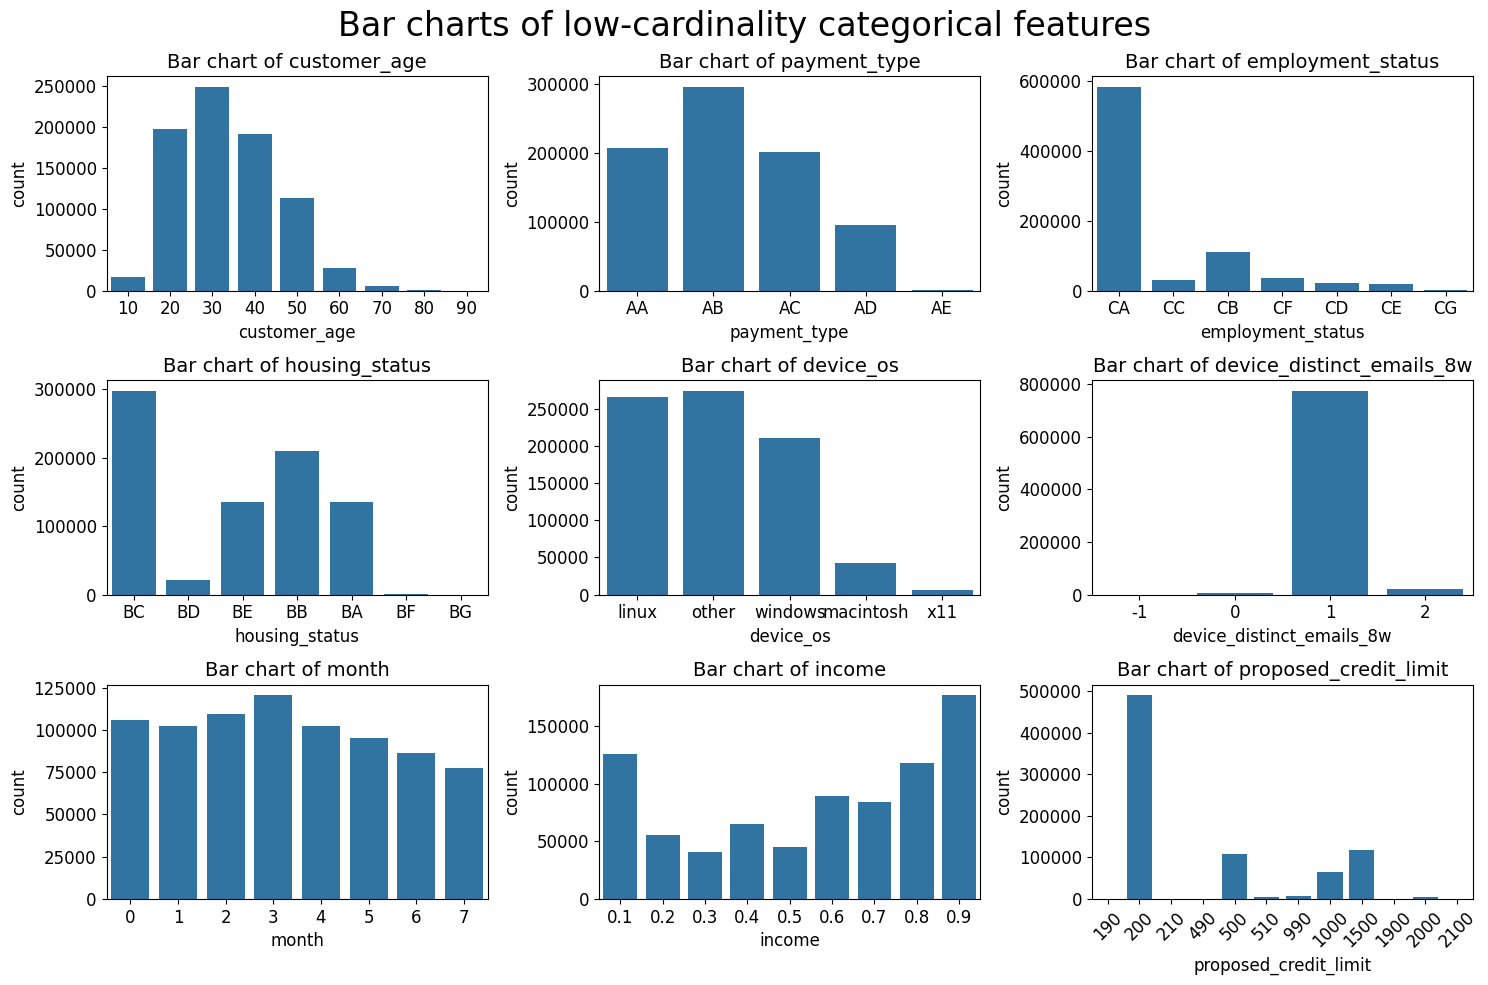

In [17]:
# Create bar charts for low-cardinality categorical features
fig, axes = plt.subplots(3, 3, figsize=(15, 10))  
axes = axes.flatten()

for i in range(len(lowcard_df.columns)):
    sns.countplot(x=lowcard_df.iloc[:, i], ax=axes[i])
    axes[i].set_title(f"Bar chart of {lowcard_df.columns[i]}", fontsize=14)  
    if (i == 8):
         axes[i].tick_params(axis='x', labelsize=12, rotation=45)  
    else:
        axes[i].tick_params(axis='x', labelsize=12)  
    axes[i].tick_params(axis='y', labelsize=12)  

    axes[i].set_xlabel(axes[i].get_xlabel(), fontsize=12)  
    axes[i].set_ylabel(axes[i].get_ylabel(), fontsize=12)  

fig.suptitle('Bar charts of low-cardinality categorical features', fontsize=24)
plt.subplots_adjust(top=0.9, hspace=0.3)
plt.tight_layout()
plt.show()




/var/folders/1m/4hl80x1s3cl168q7ptrb2zqw0000gn/T/ipykernel_46508/114377941.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='fraud_bool', data=frequency_of_1s, ax=axes[i], palette='Blues_d')
/var/folders/1m/4hl80x1s3cl168q7ptrb2zqw0000gn/T/ipykernel_46508/114377941.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='fraud_bool', data=frequency_of_1s, ax=axes[i], palette='Blues_d')
/var/folders/1m/4hl80x1s3cl168q7ptrb2zqw0000gn/T/ipykernel_46508/114377941.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f

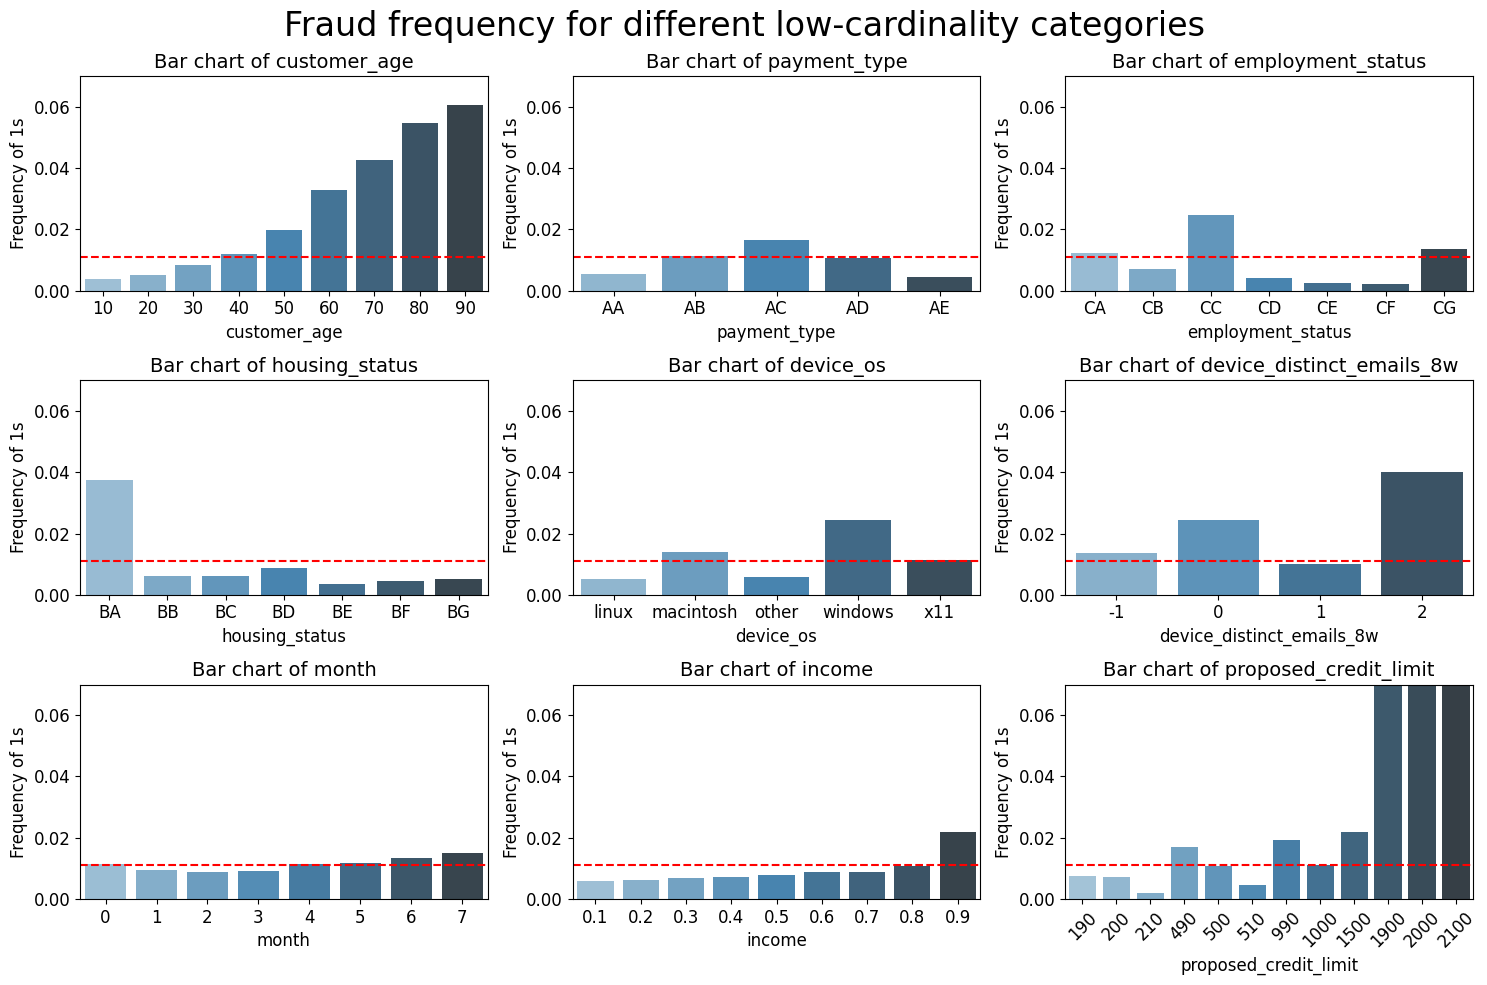

In [18]:
# Plot frequency distributions for low-cardinality categorical features 
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

y_limit = (0, 0.07)  

for i in range(len(lowcard_df.columns)):
    feature = lowcard_df.columns[i]
    frequency_of_1s = train_df.groupby(lowcard_df[feature])['fraud_bool'].mean().reset_index()
    sns.barplot(x=feature, y='fraud_bool', data=frequency_of_1s, ax=axes[i], palette='Blues_d')
    axes[i].set_title(f"Bar chart of {feature}", fontsize=14)
    axes[i].set_ylim(y_limit)
    axes[i].axhline(y=0.011, color='red', linestyle='--', linewidth=1.5)
    if i == 8:
        axes[i].tick_params(axis='x', labelsize=12, rotation=45)
    else:
        axes[i].tick_params(axis='x', labelsize=12)
    
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].set_xlabel(axes[i].get_xlabel(), fontsize=12)
    axes[i].set_ylabel('Frequency of 1s', fontsize=12)


fig.suptitle('Fraud frequency for different low-cardinality categories', fontsize=24)

plt.subplots_adjust(top=0.9, hspace=0.3)
plt.tight_layout()
plt.show()

In [19]:
# Find missing values in numerical columns
for column in num_df.columns:
    missing_values = train_df[column] < 0  # Assuming negative values represent missing data <---- This is not really correct. The negative values convey information as seen above 
    print(f"{column} has {missing_values.sum()} missing values")
    
    # SHOULD BE MOVED TO DATAPREPROCESSING? 

    # Replace negative values with NaN
    train_df[column] = train_df[column].replace(-1, np.nan) # <------ Why NaN? Doing more EDA shows that velocity_6w can be replaced with 0 and 


name_email_similarity has 0 missing values
days_since_request has 0 missing values
intended_balcon_amount has 593868 missing values
velocity_6h has 36 missing values
velocity_24h has 0 missing values
velocity_4w has 0 missing values
session_length_in_minutes has 1623 missing values


In [20]:
# SHOULD BE MOVED TO DATAPREPROCESSING?

# One-hot encoding for categorical variables
encoded_train_df = pd.get_dummies(train_df, columns=cat_df.columns, drop_first=True)


In [21]:
# SHOULD BE MOVED TO DATAPREPROCESSING?

# Apply log transformation
for column in ['velocity_6h', 'velocity_24h', 'zip_count_4w']:
    train_df[column] = np.log1p(train_df[column])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Looking at the distributions and fraud probabilities above, we can see several interesting patterns in our low-cardinality features. The income and proposed_credit_limit features show a clear U-shaped relationship with fraud probability, where both very low and very high values are associated with higher fraud rates (~4-5%) compared to middle values (~1%). This suggests these features should not be treated as ordinal despite their numerical nature.

The housing_type and employment_status features reveal specific high-risk categories. For housing, the "Other" and "Parents" categories show elevated fraud rates of 3-4%, while "Own" shows the lowest at ~0.5%. In employment, "Unemployed" stands out with the highest fraud rate (~5%), followed by "Self-employed" (~2%), while "Employed" shows the lowest risk (~0.8%).

The purpose and source features demonstrate clear category-specific risks. Business and "Other" purposes have fraud rates around 3%, while home improvement shows the lowest at ~0.5%. The source feature is highly imbalanced, with minor sources showing significantly higher fraud rates (4-5%) compared to the dominant source (~1%).

Time_at_employer is unique among these features as it shows a clear linear relationship - fraud probability consistently decreases as employment duration increases. This suggests it could potentially be treated as an ordinal feature rather than nominal.

Browser language and employment industry also show meaningful variations in fraud rates. Non-dominant languages are associated with higher fraud rates (3-4%) compared to the dominant language (~1%). In industry categories, Technology and Finance show higher fraud rates (~2-3%) while Healthcare and Education show lower rates (~0.5%).

### Summary by feature

Income and Proposed Credit Limit: Use one-hot encoding to preserve U-shaped relationship and watch for potential multicollinearity between these features

Housing Type and Employment Status: Apply one-hot encoding and keep all categories as they show distinct risk profiles

Purpose: Use one-hot encoding, and all categories contain valuable information about fraud risk

Source: Apply one-hot encoding, consider combining rare categories due to high imbalance

Time at Employer: Consider ordinal encoding due to clear linear relationship, or alternatively, one-hot encoding if non-linear aspects emerge in modeling

Browser Language: Use one-hot encoding, consider combining rare categories, and keep dominant language as reference category

Employment Industry: Apply one-hot encoding and keep all categories as they show distinct risk profiles

### 2.2c) Boolean features

# Correlation analysis - TODO